In [1]:
from census import Census
from config import (census1_api_key, census2_api_key, weather_api_key, gkey)
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import os
import numpy as np
from census import Census
import gmaps
import csv
import matplotlib.pyplot as plt
import openweathermapy as ow
import time


# Collect and prep homeless data from US Census bureau


In [2]:
url = "https://api.census.gov/data/2010/dec/sf1?get=PCT020B027,PCT020D027,PCT020E027,PCT021093,PCT021061,PCT021029,PCT021190,PCT021126,PCT021158,PCT020H027,PCT020A027,PCT020I027,PCT020C027,PCT020027,PCT020F027,PCT020G027,NAME&for=county:*&key=" + census1_api_key
response = requests.get(url)
response_json = response.json()

census_pd = pd.DataFrame(response_json)

census_pd.columns = census_pd.iloc[0]
census_pd = census_pd[1:]

census_pd["County"] = census_pd["NAME"].str.split(pat=",", expand=True)[0]
census_pd["State"] = census_pd["NAME"].str.split(pat=",", expand=True)[1]

del census_pd["state"]
del census_pd["county"]
del census_pd["NAME"]

#Get list of population columns
cols = census_pd.columns.drop(["County","State"])

#Convert population columns to numeric
census_pd[cols] = census_pd[cols].apply(pd.to_numeric)

#Sum poplulation columns to one column
census_pd["Homeless Pop"] = census_pd.sum(axis=1)

#Select desired columns to final homeless dataframe 
homeless_data = census_pd[["County", "State", "Homeless Pop"]]

homeless_data.head()

,County,State,Homeless Pop
1,Autauga County,Alabama,0
2,Bibb County,Alabama,0
3,Chambers County,Alabama,0
4,Cherokee County,Alabama,0
5,Clarke County,Alabama,0


# Prep home value data from csv file downloaded from Zillow

In [4]:
# Real Estate Data

re_prices=pd.read_csv("County_Zhvi_Summary_AllHomes.csv",encoding="ISO-8859-1")
re_prices

states = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}

state_expanded=[]
state_abbreviated=[]

for key in states.keys():
    state_expanded.append(states[key])
    state_abbreviated.append(key)
    
    
state=pd.DataFrame({"state_a":state_abbreviated,"state_e":state_expanded})

re_prices_2=pd.merge(re_prices,state,left_on="State",right_on="state_a",how="left")

re_prices_2=re_prices_2.loc[:,["RegionName","state_e","Zhvi","YoY"]]

re_prices_2.loc[:,"Price_2018"]=re_prices_2["Zhvi"]/(1+re_prices["YoY"])

re_prices_2=re_prices_2.rename(columns={"RegionName":"County","state_e":"State"})

re_prices_2=re_prices_2.iloc[:,[0,1,4]]

re_prices_2.to_csv("Price_by_County.csv")

re_prices_2.head()

,County,State,Price_2018
0,Los Angeles County,California,595599.999948
1,Cook County,Illinois,216799.999961
2,Harris County,Texas,178300.000006
3,Maricopa County,Arizona,253099.999972
4,San Diego County,California,572099.999973


# Collect and prep poverty data from Census Bureau

In [5]:
#Poverty Data

# Configure gmaps
gmaps.configure(api_key=gkey)


In [6]:
name = "?get=NAME,"
population = "B01003_001E"
poverty_count = "B17001_002E"
county = "for=county:*"

base_url = "https://api.census.gov/data/2017/acs/acs5"
query_url = base_url + name + population + "&" + poverty_count + "&" + county + "&key=" + census2_api_key
query_url

'https://api.census.gov/data/2017/acs/acs5?get=NAME,B01003_001E&B17001_002E&for=county:*&key=e4802ddb92bf7b297f5f10de4176b9d5341c10c8'

In [7]:
census_response = requests.get(query_url)
census_response = census_response.json()

# Convert to DataFrame
poverty_data = pd.DataFrame(census_response)

#replace header with row 1
new_header = poverty_data.iloc[0] #grab the first row for the header
poverty_data = poverty_data[1:] #take the data less the header row
poverty_data.columns = new_header #set the header row as the df header

# Column Reordering
poverty_data = poverty_data.rename(columns={"B01003_001E": "Population",
                                            "B17001_002E": "Poverty Count",
                                            "NAME": "Name", 
                                            "state": "State",
                                            "county":"County"})

# Add in Poverty Rate (Poverty Count / Population)
poverty_data["Poverty Rate"] = 100 * poverty_data["Poverty Count"].astype(int) / poverty_data["Population"].astype(int)


In [8]:
poverty_data["County"] = poverty_data["Name"].str.split(pat=",", expand=True)[0]
poverty_data["State"] = poverty_data["Name"].str.split(pat=",", expand=True)[1]
# Parse Final DataFrame
poverty_data = poverty_data[["County","State","Population","Poverty Rate"]]
poverty_data.head()

,County,State,Population,Poverty Rate
1,Corozal Municipio,Puerto Rico,34933,54.807775
2,Maunabo Municipio,Puerto Rico,11297,52.624591
3,Peñuelas Municipio,Puerto Rico,21661,57.148793
4,Ponce Municipio,Puerto Rico,148863,50.507514
5,San Sebastián Municipio,Puerto Rico,38970,55.098794


# Collect and prep weather data

In [ ]:
county_df = pd.read_csv("Weather Files/county_coordinates_edits.csv")

county_df["Temp"] = ""

for i, row in county_df.iterrows():
    
    lat = row["lat"]
    lon = row["lng"]
    
    try:
        response = requests.get(f"http://api.openweathermap.org/data/2.5/weather?units=Imperial&lat={lat}&lon={lon}&appid={weather_api_key}").json()

        county_df.loc[i,"Temp"] = response["main"]["temp_max"]
       
    except:
        print("Location not found. Skipping...")
        continue

temp_data_df = county_df[["County", "State", "Temp"]]
temp_data_df.head() = county_df[["County", "State", "Temp"]]


In [14]:
county_df = pd.read_csv("combined_data.csv")
temp_data_df = county_df[["County", "State", "Temp"]]
temp_data_df.head()

,County,State,Temp
0,autauga county,alabama,39.20
1,cherokee county,alabama,24.80
2,blount county,alabama,37.00
3,chilton county,alabama,25.00
4,coffee county,alabama,60.01


# Merge data sets

In [15]:
#Merging Homeless and Poverty data

homeless_data["County"] = homeless_data["County"].map(lambda x: x.lower())
homeless_data["State"] = homeless_data["State"].map(lambda x: x.lower())

poverty_data["County"] = poverty_data["County"].map(lambda x: x.lower())
poverty_data["State"] = poverty_data["State"].map(lambda x: x.lower())

re_prices_2["County"] = re_prices_2["County"].map(lambda x: x.lower())
re_prices_2["State"] = re_prices_2["State"].map(lambda x: x.lower())

temp_data_df["County"] = re_prices_2["County"].map(lambda x: x.lower())
temp_data_df["State"] = re_prices_2["State"].map(lambda x: x.lower())




combined_data = homeless_data.merge(poverty_data, on = ["County", "State"], how = "left")

combined_data["State"] = combined_data['State'].str.strip()

combined_data = combined_data.merge(re_prices_2, how = "right")

combined_data = combined_data.merge(temp_data_df, how = "left")

combined_data["Population"] = combined_data["Population"].apply(pd.to_numeric)
combined_data["Homeless Rate"] = combined_data["Homeless Pop"] /combined_data["Population"]



combined_data.head()
combined_data.to_csv("combined_data.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [16]:
 combined_data.head()


,County,State,Homeless Pop,Population,Poverty Rate,Price_2018,Temp,Homeless Rate
0,autauga county,alabama,0.0,55036.0,13.596555,144599.999971,39.2,0.000000
1,cherokee county,alabama,0.0,25855.0,15.873139,102899.999979,73.4,0.000000
2,blount county,alabama,0.0,57667.0,15.466385,132499.999941,70.0,0.000000
3,chilton county,alabama,0.0,43805.0,19.157630,114299.999990,66.2,0.000000
4,coffee county,alabama,64.0,51073.0,15.902727,109500.000045,37.4,0.001253


# Plots

Poverty versus Homelessness
Spearman correlation coefficient: 0.03; Probability of not equalling zero: 0.78
Pearson correlation coefficient: 0.08; Probability of not equalling zero: 1.0


Text(0, 0.5, 'Homeless Rate')

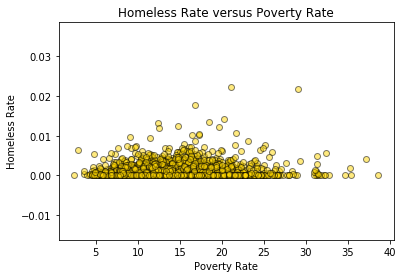

In [17]:
from scipy.stats import (pearsonr,spearmanr)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

plot_data=combined_data.dropna()

plot_data.shape

s_corr, s_p =spearmanr(plot_data["Poverty Rate"],plot_data["Homeless Rate"])
p_corr, p_p =pearsonr(plot_data["Poverty Rate"],plot_data["Homeless Rate"])
print("Poverty versus Homelessness")
print(f"Spearman correlation coefficient: {round(s_corr,2)}; Probability of not equalling zero: {round(1-s_p,2)}")
print(f"Pearson correlation coefficient: {round(p_corr,2)}; Probability of not equalling zero: {round(1-p_p,2)}")
plt.scatter(plot_data["Poverty Rate"],plot_data["Homeless Rate"],  marker="o", 
            facecolors="gold", edgecolors="black", alpha=.5, linewidths=1)
#plot title, axes labels
plt.title("Homeless Rate versus Poverty Rate")
plt.xlabel("Poverty Rate")
plt.ylabel("Homeless Rate")


Homelessness versus Temperature
Spearman correlation coefficient: 0.03; Probability of not equalling zero: 0.77
Pearson correlation coefficient: 0.03; Probability of not equalling zero: 0.76


Text(0, 0.5, 'Homeless Rate')

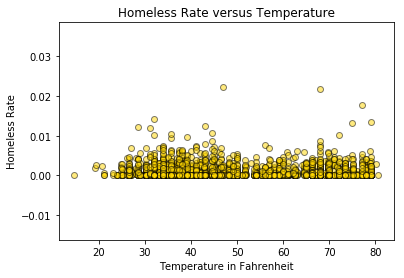

In [18]:
s_corr, s_p =spearmanr(plot_data["Temp"],plot_data["Homeless Rate"])
p_corr, p_p =pearsonr(plot_data["Temp"],plot_data["Homeless Rate"])
print("Homelessness versus Temperature")
print(f"Spearman correlation coefficient: {round(s_corr,2)}; Probability of not equalling zero: {round(1-s_p,2)}")
print(f"Pearson correlation coefficient: {round(p_corr,2)}; Probability of not equalling zero: {round(1-p_p,2)}")
plt.scatter(plot_data["Temp"],plot_data["Homeless Rate"],  marker="o", 
            facecolors="gold", edgecolors="black", alpha=.5, linewidths=1)
#plot title, axes labels
plt.title("Homeless Rate versus Temperature")
plt.xlabel("Temperature in Fahrenheit")
plt.ylabel("Homeless Rate")

Homelessness versus House Prices
Spearman correlation coefficient: 0.29; Probability of not equalling zero: 1.0
Pearson correlation coefficient: 0.29; Probability of not equalling zero: 1.0


Text(0, 0.5, 'Homeless Rate')

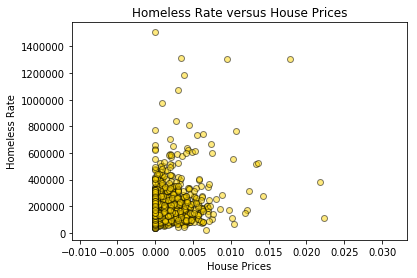

In [19]:
s_corr, s_p =spearmanr(plot_data["Price_2018"],plot_data["Homeless Rate"])
p_corr, p_p =pearsonr(plot_data["Price_2018"],plot_data["Homeless Rate"])
print("Homelessness versus House Prices")
print(f"Spearman correlation coefficient: {round(s_corr,2)}; Probability of not equalling zero: {round(1-s_p,2)}")
print(f"Pearson correlation coefficient: {round(p_corr,2)}; Probability of not equalling zero: {round(1-p_p,2)}")
plt.scatter(plot_data["Homeless Rate"],plot_data["Price_2018"],  marker="o", 
            facecolors="gold", edgecolors="black", alpha=.5, linewidths=1)
#plot title, axes labels
plt.title("Homeless Rate versus House Prices")
plt.xlabel("House Prices")
plt.ylabel("Homeless Rate")